# Análise Exploratória dos Dados de Prefeitos (2k-200k habitantes)

Este notebook apresenta uma análise exploratória do arquivo `dados_unificados_prefeitos_200k.csv`, que consolida as informações de resultados eleitorais, valores de emendas PIX e indicadores socioeconômicos dos municípios.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')
pd.options.display.float_format = '{:.2f}'.format

path = '../data/dados_unificados_prefeitos_200k.csv'
df = pd.read_csv(path)
df.head()

## Visão Geral

A primeira etapa consiste em verificar o formato da base e o tipo das variáveis.

In [ ]:
df.shape, df.dtypes

In [ ]:
df.isna().sum()

# Count 0 values in 'emendas_pix_per_capita_partido_prefeito_eleito'
df.emendas_pix_per_capita_partido_prefeito_eleito.value_counts()

In [ ]:
df.describe().round(2)

### Filtragem de casos sem emendas ou com votação unânime
As análises a seguir desconsideram municípios que receberam soma zero de Emendas PIX ou onde apenas um candidato concorreu (100% dos votos válidos).

## Distribuições

As distribuições das variáveis numéricas ajudam a identificar possíveis assimetrias e a presença de outliers.

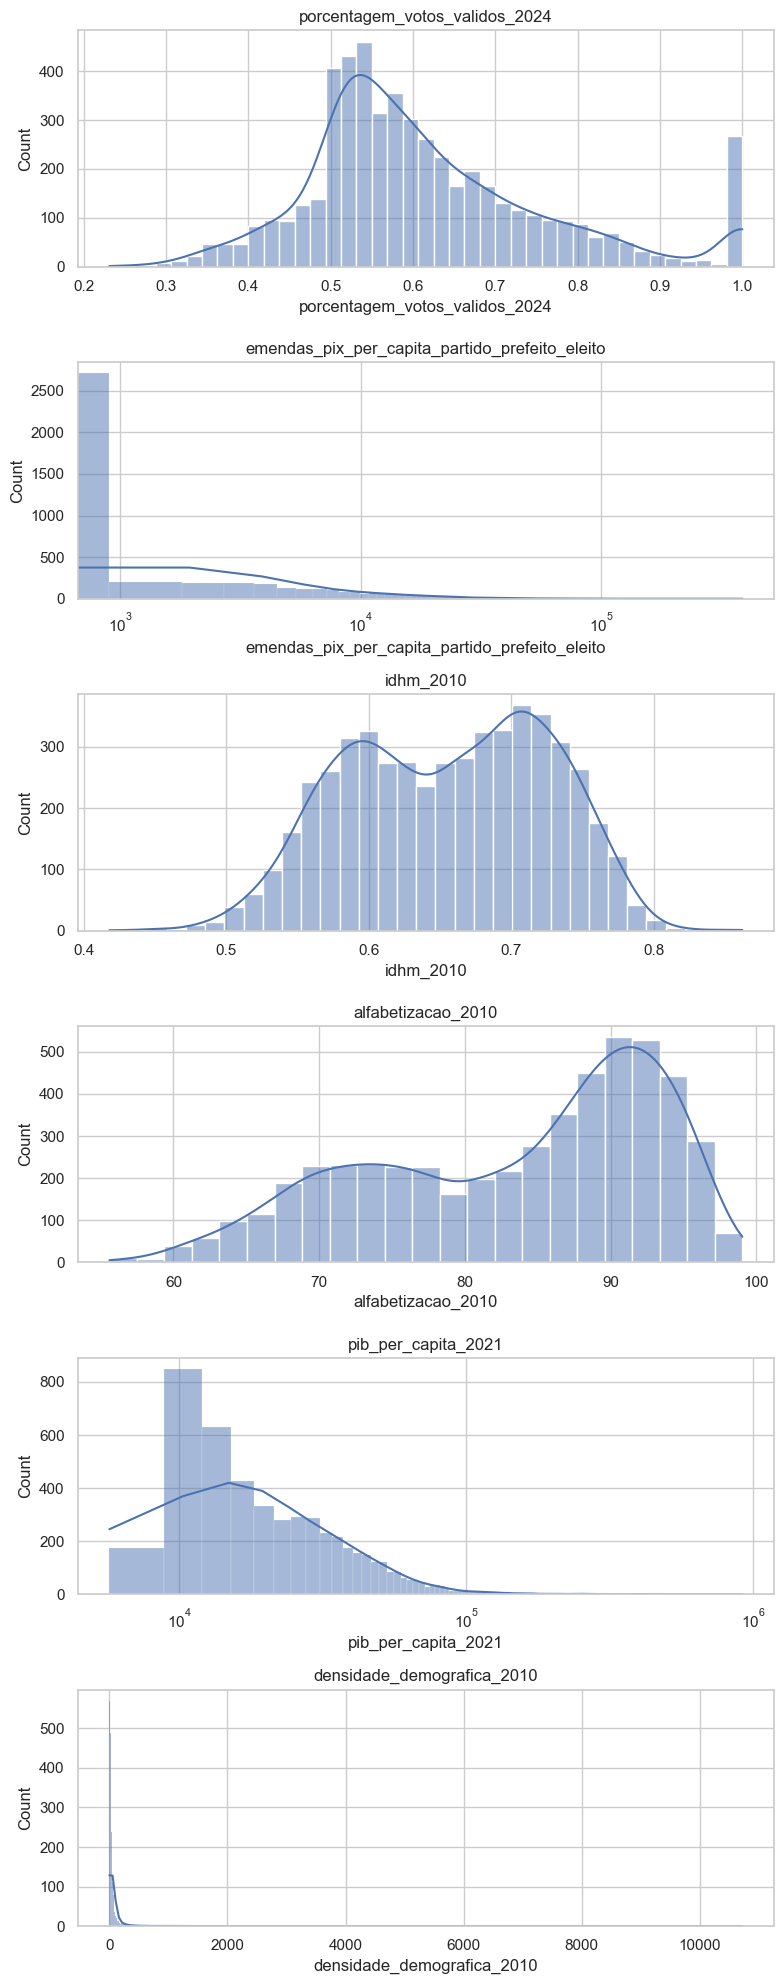

In [5]:
num_cols = ['porcentagem_votos_validos_2024', 'emendas_pix_per_capita_partido_prefeito_eleito',
            'idhm_2010', 'alfabetizacao_2010', 'pib_per_capita_2021', 'densidade_demografica_2010']
# Gera um histograma para cada variável
fig, axes = plt.subplots(len(num_cols), 1, figsize=(8, 20))
for ax, col in zip(axes, num_cols):
    sns.histplot(data=df, x=col, kde=True, ax=ax)
    if col in ['emendas_pix_per_capita_partido_prefeito_eleito', 'pib_per_capita_2021']:
        ax.set_xscale('log')
    ax.set_title(col)
plt.tight_layout()

## Partidos

Analisamos a distribuição das siglas partidárias e o desempenho médio por partido.

In [6]:
party_counts = df['sigla_partido_prefeito_eleito'].value_counts().head(30)
party_counts

sigla_partido_prefeito_eleito
PSD              838
MDB              812
PP               713
UNIÃO            545
PL               467
REPUBLICANOS     409
PSB              302
PSDB             259
PT               240
PDT              139
AVANTE           130
PODE             112
PRD               73
SOLIDARIEDADE     61
CIDADANIA         31
PC do B           19
MOBILIZA          18
NOVO              16
PV                13
REDE               4
AGIR               3
PMB                2
DC                 2
Name: count, dtype: int64

In [7]:
party_perf = df.groupby('sigla_partido_prefeito_eleito')['porcentagem_votos_validos_2024'].mean().sort_values(ascending=False)
party_perf.head(30)

sigla_partido_prefeito_eleito
AGIR            0.84
REDE            0.69
CIDADANIA       0.66
PSB             0.63
PSD             0.63
MOBILIZA        0.63
MDB             0.63
PC do B         0.62
UNIÃO           0.62
PRD             0.62
REPUBLICANOS    0.62
AVANTE          0.62
PP              0.61
PDT             0.60
PSDB            0.60
PT              0.60
PODE            0.59
PL              0.59
SOLIDARIEDADE   0.58
PV              0.55
NOVO            0.54
PMB             0.53
DC              0.50
Name: porcentagem_votos_validos_2024, dtype: float64

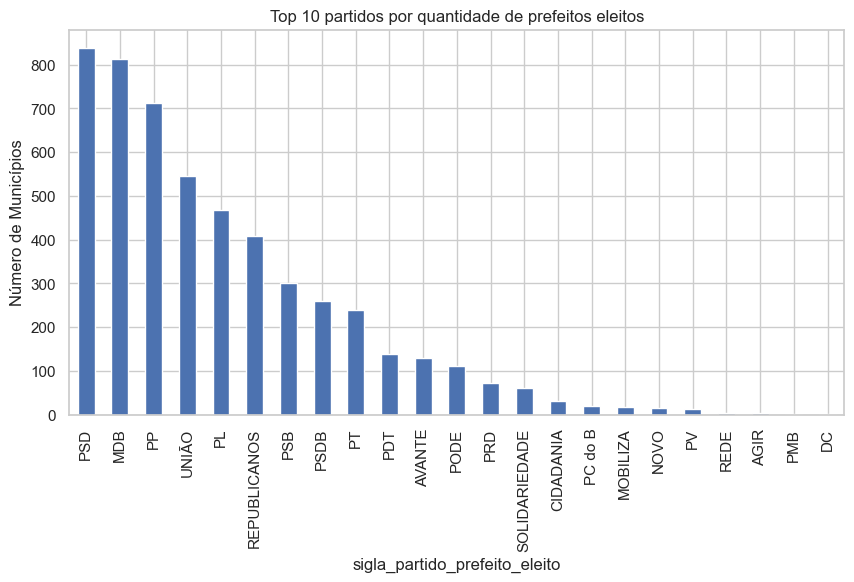

In [9]:
fig, ax = plt.subplots(figsize=(10,5))
party_counts.plot(kind='bar', ax=ax)
ax.set_ylabel('Número de Municípios')
ax.set_title('Top 10 partidos por quantidade de prefeitos eleitos')
plt.show()


## Relação entre Emendas PIX per capita e Desempenho Eleitoral

Verificamos se há correlação entre o valor das emendas recebidas e a proporção de votos válidos.

In [ ]:
# # Primeiro, retirar os valores 0 de emendas_pix_per_capita_partido_prefeito_eleito
df = df[df['emendas_pix_per_capita_partido_prefeito_eleito'] > 0]
# Contagem de casos removidos
total = len(df)
count_100 = (df['porcentagem_votos_validos_2024'] >= 1).sum()
count_zero = (df['emendas_pix_per_capita_partido_prefeito_eleito'] == 0).sum()
print(f'Total de municípios: {total}')
print(f'Casos com 100% dos votos válidos: {count_100}')
print(f'Casos com soma de emendas PIX igual a 0: {count_zero}')

# Filtrar dados para a análise
df = df[(df['emendas_pix_per_capita_partido_prefeito_eleito'] > 0) &
        (df['porcentagem_votos_validos_2024'] < 1)]

# Utilizar escala adequada para o gráfico
df['emendas_pix_per_capita_partido_prefeito_eleito'] = np.log1p(df['emendas_pix_per_capita_partido_prefeito_eleito'])

fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(data=df, x='emendas_pix_per_capita_partido_prefeito_eleito', y='porcentagem_votos_validos_2024', alpha=0.6, ax=ax)
sns.regplot(data=df, x='emendas_pix_per_capita_partido_prefeito_eleito', y='porcentagem_votos_validos_2024', scatter=False, color='red', ax=ax)
ax.set_xlabel('PIX per capita (mesmo partido)')
ax.set_ylabel('Proporção de votos válidos 2024')
plt.show()

## Correlações

Matriz de correlação entre as variáveis numéricas.

In [ ]:
corr = df[num_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Matriz de correlação')
plt.show()


## Relação entre IDHM e Proporção de Votos Válidos

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(data=df, x='idhm_2010', y='porcentagem_votos_validos_2024', alpha=0.6, ax=ax)
sns.regplot(data=df, x='idhm_2010', y='porcentagem_votos_validos_2024', scatter=False, color='red', ax=ax)
ax.set_xlabel('IDHM 2010')
ax.set_ylabel('Proporção de votos válidos 2024')
plt.show()